# CTR Prediction with Stochastic Gradient Descent #

The goal of this project is to predict whether mobile advertisements will be clicked. I'll use stochastic gradient descent algorithm called Pegasos, an algorithm commonly used for [click-through rate (CTR)](https://en.wikipedia.org/wiki/Click-through_rate#:~:text=Click%2Dthrough%20rate%20(CTR))  predictions.  
> Click-through rate (CTR) is the ratio of users who click on a specific link to the number of total users who view a page, email, or advertisement. It is commonly used to measure the success of an online advertising campaign for a particular website as well as the effectiveness of email campaigns.  

CTR prediction systems are essential to informing decisions related to sponsored search and real-time bidding.

## Contents: ##
1. [Dataset Description](#s1)
2. [Preprocessing](#s2)  
3. [A Generic Classifier Object](#s3)
4. [Decision Boundary Plot Function](#s4)
5. [Regularized Logistic Regression Classifier](#s5)
6. [Regularized Hinge Loss Support Vector Machine Classifier](#s6)
7. [Implementing the Pegasos Algorithm](#s7)
8. [Pegasos on Criteo CTR Prediction Data](#s8)
9. [TODO](#s9)

----
<a id='s1'></a>
## 1. Dataset Description###
### Data Source:###
The data is sourced from [CriteoLabs](https://labs.criteo.com/), a multinational corporation in the digital marketing industry, specializing in algorithmic approaches to determine what to show users. In an [old kaggle competition](https://www.kaggle.com/c/criteo-display-ad-challenge), 7 days worth of Criteo's ad data was released. From here on out, this will be referred to as "the Criteo data" in the notebook. The Criteo data is contained in the  'train_subsampled.csv' file. 

### Data Fields

- Label - Target variable that indicates if an ad was clicked (1) or not (0).
- I1-I13 - A total of 13 columns of integer features (mostly count features).
- C1-C26 - A total of 26 columns of categorical features. The values of these features have been hashed onto 32 bits for anonymization purposes.  

The semantics of the features remain undisclosed.  
  When a value is missing, the field is empty.

----
<a id='s2'></a>
## 2. Preprocessing ##
This section involves loading a sample of the Criteo data and preprocessing categorical features with one-hot-encoding. 

**One-hot encoding** is a method for turning categorical variables into continuous variables when no ordinal relationship exists. Most ML algorithms require numerical input, similar to the ones in this notebook.

In [30]:
# Necessary imports from data science stack
from matplotlib import colors
import matplotlib.pyplot as plt
import numpy as np
import scipy
import seaborn as sns; sns.set()

from sklearn.preprocessing import OneHotEncoder # for preprocessing
from scipy.optimize import minimize
from numpy.lib import recfunctions as rfn

# built-in modules used
import math
import pprint

In [6]:
# Load the training data and find out the feature labels.

# load in data as a np array
labeled_data = np.genfromtxt(
        'train_subsampled.csv', dtype=float, delimiter=',', names=True) 
# To instead load in a pd array, use `pd.read_csv`
print(len(labeled_data), ' training points found.')
print('\n There are a total of ', len(labeled_data.dtype), ' features.')

20000  training points found.

 There are a total of  24  features.


In [5]:
labeled_data[0]

(4.43939437e+18, 0., 14102923., 1005., 0., nan, nan, nan, nan, nan, nan, nan, nan, nan, 1., 0., 15706., 320., 50., 1722., 0., 35., -1., 79.)

In [13]:
np.shape(labeled_data)

(20000,)

In [15]:
pd.read_csv?

In [26]:
import pandas as pd
data = pd.read_csv('train_subsampled.csv')
print('Dataset shape: ', data.shape)
print('\nDataset columns: \n', data.columns)

Dataset shape:  (20000, 24)

Dataset columns: 
 Index(['id', 'click', 'hour', 'C1', 'banner_pos', 'site_id', 'site_domain',
       'site_category', 'app_id', 'app_domain', 'app_category', 'device_id',
       'device_ip', 'device_model', 'device_type', 'device_conn_type', 'C14',
       'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21'],
      dtype='object')


In [22]:
data.head(2)

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,4439394373268869066,0,14102923,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15706,320,50,1722,0,35,-1,79
1,14489770110436898243,0,14102518,1005,1,5b4d2eda,16a36ef3,f028772b,ecad2386,7801e8d9,...,1,0,20632,320,50,2374,3,39,100148,23


In [49]:
df['click'].value_counts()

0.0    16646
1.0     3354
Name: click, dtype: int64

In [50]:
df['id'].value_counts()

1.463304e+19    1
9.863963e+18    1
8.480513e+18    1
5.974140e+18    1
6.993888e+18    1
               ..
5.852669e+18    1
3.552678e+18    1
1.049839e+18    1
5.245938e+18    1
1.352435e+19    1
Name: id, Length: 20000, dtype: int64

['id',
 'click',
 'hour',
 'C1',
 'banner_pos',
 'site_id',
 'site_domain',
 'site_category',
 'app_id',
 'app_domain',
 'app_category',
 'device_id',
 'device_ip',
 'device_model',
 'device_type',
 'device_conn_type',
 'C14',
 'C15',
 'C16',
 'C17',
 'C18',
 'C19',
 'C20',
 'C21']

In [56]:
df.agg(['nunique', 'count', 'size'])

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
nunique,20000,2,240,7,6,25,11,2,24,2,...,4,4,1202,6,7,351,4,61,136,58
count,20000,20000,20000,20000,20000,83,1780,1553,194,401,...,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000
size,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,...,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000


'id' : No relevant information

In [11]:
df = pd.DataFrame(labeled_data)
df

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,4.439394e+18,0.0,14102923.0,1005.0,0.0,NaN,NaN,NaN,NaN,NaN,...,1.0,0.0,15706.0,320.0,50.0,1722.0,0.0,35.0,-1.0,79.0
1,1.448977e+19,0.0,14102518.0,1005.0,1.0,NaN,NaN,NaN,NaN,NaN,...,1.0,0.0,20632.0,320.0,50.0,2374.0,3.0,39.0,100148.0,23.0
2,5.188284e+18,0.0,14102109.0,1005.0,0.0,NaN,NaN,NaN,NaN,NaN,...,1.0,0.0,21760.0,320.0,50.0,2502.0,0.0,35.0,-1.0,221.0
3,1.070857e+19,0.0,14102406.0,1005.0,0.0,NaN,NaN,NaN,NaN,NaN,...,1.0,0.0,456.0,320.0,50.0,122.0,3.0,1327.0,100013.0,15.0
4,4.824233e+18,0.0,14102507.0,1010.0,1.0,NaN,NaN,NaN,NaN,NaN,...,4.0,2.0,17877.0,320.0,50.0,2036.0,3.0,47.0,-1.0,156.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,9.368645e+18,0.0,14102619.0,1005.0,0.0,NaN,NaN,NaN,NaN,NaN,...,1.0,3.0,21191.0,320.0,50.0,2424.0,1.0,161.0,100193.0,71.0
19996,1.237151e+19,0.0,14102109.0,1005.0,1.0,NaN,NaN,NaN,NaN,NaN,...,1.0,0.0,19950.0,320.0,50.0,1800.0,3.0,167.0,100074.0,23.0
19997,8.159734e+17,0.0,14102811.0,1002.0,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,6366.0,300.0,50.0,544.0,3.0,39.0,100079.0,23.0
19998,4.530238e+18,1.0,14102214.0,1005.0,0.0,NaN,NaN,NaN,NaN,NaN,...,1.0,0.0,18094.0,320.0,50.0,2060.0,3.0,39.0,100241.0,23.0


In [12]:
df.shape

(20000, 24)

In [6]:
# features used for classification
features_to_use = ['click', 'C1', 'device_type', 'C15', 'C16']
labeled_data = labeled_data[features_to_use]
print(len(labeled_data), ' training points found with the features: ')
print(labeled_data.dtype)
print('A total of ', len(labeled_data.dtype), ' features.')

# Convert the labeled data into unstructured array.
labeled_data = rfn.structured_to_unstructured(labeled_data)
labeled_data_X = labeled_data[:, 1:]
labeled_data_Y = labeled_data[:, 0]

# Currently, the Y's in the Criteo data are in {0, 1}.
# Convert all 0's to -1's instead.
for i in range(labeled_data_Y.shape[0]):
    labeled_data_Y[i] = 1 if labeled_data_Y[i] > 0 else -1

20000  training points found with the features: 
{'names':['click','C1','device_type','C15','C16'], 'formats':['<f8','<f8','<f8','<f8','<f8'], 'offsets':[8,24,112,136,144], 'itemsize':192}
A total of  5  features.


The `<f8` data type may be a bit confusing to you. First off, the `<` in the dtype indicates the [byte order](https://numpy.org/doc/stable/reference/generated/numpy.dtype.byteorder.html). `<` is the little-endian indicator. 
> On [Endianness](https://en.wikipedia.org/wiki/Endianness): In computing, endianness is the ordering or sequencing of bytes of a word of digital data in computer memory storage or during transmission. Endianness is primarily expressed as big-endian or little-endian. Big-endian systems store the most significant byte of a word at the smallest memory address and the least significant byte at the largest. A little-endian system, in contrast, stores the least-significant byte at the smallest address.

`f8` indicates that the respective column has a float datatype. 

In [37]:
def preprocess_one_hot_encoding(labeled_data_X, labeled_data_Y):
    """Converts an unstructued 2-D array consisting of categorical values
    into a 2-D array consisting of one-hot-encoded vectors.
    """    
    # Apply one-hot-encoding.
    encoder = OneHotEncoder()
    hot_x = encoder.fit_transform(labeled_data_X).toarray()
    
    # Divide the data into train/validation.
    train_data_size = int(len(labeled_data_X)*0.8)
    
    train_data_X = hot_x[:train_data_size]
    train_data_Y = labeled_data_Y[:train_data_size]
    print('training set size: ', train_data_X.shape[0])

    val_data_X = hot_x[train_data_size:]
    val_data_Y = labeled_data_Y[train_data_size:]
    print('validation set size: ', val_data_X.shape[0])

    return train_data_X, train_data_Y, val_data_X, val_data_Y

train_data_X, train_data_Y, val_data_X, val_data_Y = \
    preprocess_one_hot_encoding(labeled_data_X, labeled_data_Y)

NameError: name 'labeled_data_X' is not defined

I'll also load a small dataset that is easily separable with logistic regression for sanity checks. It's in the 'logistic_regression.csv' file. I'm using this file to perform tests on my models before running everything on the Criteo data, since the dataset is somewhat large.

In [9]:
# Sanity check: Load the small dataset.
small_data = np.genfromtxt(
        'logistic_regression.csv',
        dtype=float,
        delimiter=',',
        names=True)
small_data = rfn.structured_to_unstructured(small_data)
print('Loaded a small dataset for sanity check: ', small_data.shape)
small_data_X = small_data[:, 0:2]
small_data_Y = small_data[:, 2]

Loaded a small dataset for sanity check:  (200, 3)


## Feature Selection

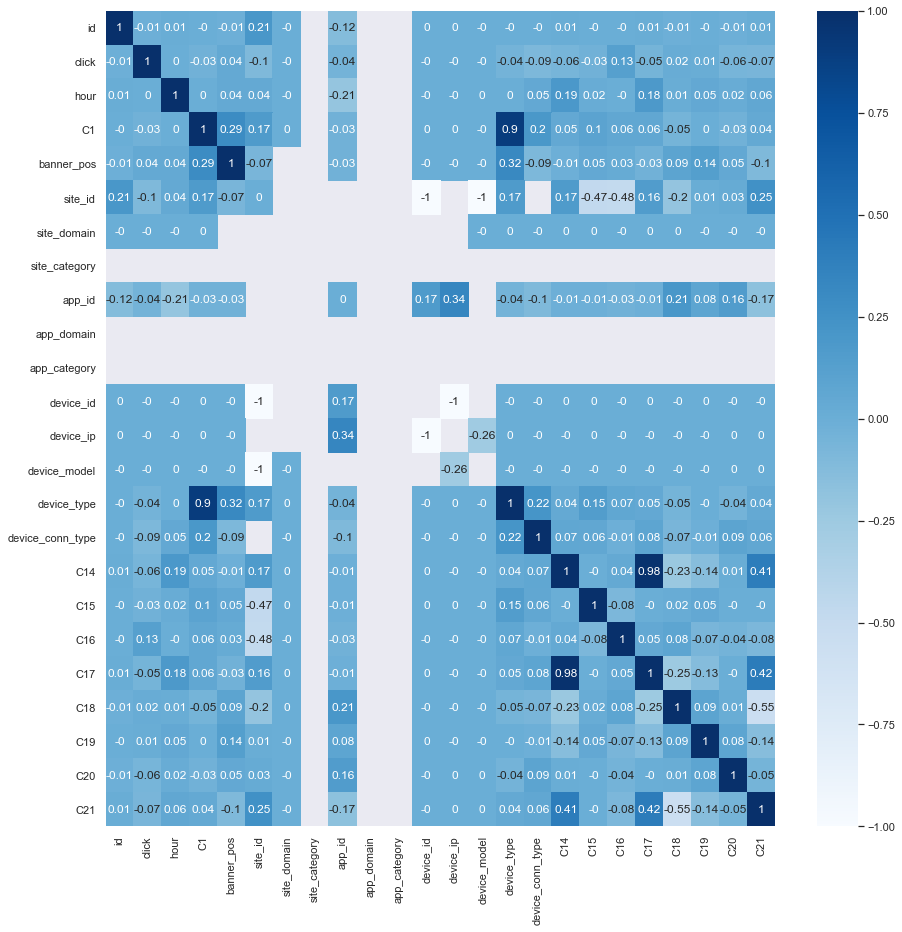

In [36]:
corr = df.corr().round(2)
plt.figure(figsize=(15, 15))
sns.heatmap(corr, annot=True, cmap='Blues')

----
<a id='s3'></a>
# 3. A Generic Classifier Object
Here is a generic classifier class with some useful functions. As we define more classifiers, we will inherit from this base class and implement supplementary methods.

In [6]:
# A class for generic classifiers.
class classifier:
    """A generic classifier object. The `weight` attribute is updated after each
    gradient step.

    """
    # Takes the number of features as an input and initializes the classifier.
    def __init__(self, n_features):
        
        # Each classifier stores a weight vector whose size is equal to the number of features.
        self.weight_ = np.zeros( (n_features,) )

    def set_mini_batch_size(self, mini_batch_size_in):
        """Sets the mini batch size used for the classifier.

        Args:
            mini_batch_size_in (int): [description]
        """
        self.mini_batch_size_ = mini_batch_size_in
    
    # 
    def init_history(self, n_epochs):
        """Initializes the history vectors.

        Args:
            n_epochs (int): the number of iterations or passes of the 
                training set the algorithm completes; equivalently, the number 
                of times the weight vectors have been updated
        """
        self.obj_val_history_ = np.zeros( (n_epochs + 1, ))
        self.l2_norm_gradient_history_ = np.zeros(( n_epochs + 1, ))
        self.training_unregularized_loss_history_ = np.zeros( (n_epochs + 1, ) )
        self.validation_unregularized_loss_history_ = np.zeros( (n_epochs + 1, ) )
    
    def batch_classify(self, x_mat):
        """[summary]

        Args:
            x_mat (array, 2D):  A matrix in which each row is a point

        Returns:
            (array, 1D): Binary classification results. An array consisting of 
                values in set {-1,1}
        """
        return np.array([ self.classify(x_vec) for x_vec in x_mat])
       
    def update_weight(self, learning_rate, weight_gradient):
        """Performs one update to the weight vector.

        Args:
            learning_rate (float): [description]
            weight_gradient ([type]): [description]
        """
        self.weight_ = self.weight_ - learning_rate * weight_gradient
    
    # Stores history of optimization progress.
    def add_to_history(self, obj_val, weight_gradient, epoch_num, X, Y,
            validation_data_X, validation_data_Y ):
        """[summary]

        Args:
            obj_val ([type]): [description]
            weight_gradient ([type]): [description]
            epoch_num ([type]): [description]
            X ([type]): [description]
            Y ([type]): [description]
            validation_data_X ([type]): [description]
            validation_data_Y ([type]): [description]
        """
        self.obj_val_history_[epoch_num] = obj_val
        self.l2_norm_gradient_history_[epoch_num] = np.linalg.norm(weight_gradient, 2)
        self.training_unregularized_loss_history_[epoch_num] = self.compute_unregularized_loss(X, Y)

        if validation_data_X is not None:
            self.validation_unregularized_loss_history_[epoch_num] = \
                self.compute_unregularized_loss(validation_data_X, validation_data_Y)

----
<a id='s4'></a>
# 4. Decision Boundary Plot Function

In [7]:
def plot_data(classifier, X, Y):
    """plots the decision boundary for a binary classifier

    Args:
        classifier ([type]): [description]
        X ([type]): [description]
        Y ([type]): [description]
    """
    weight = classifier.weight_
    y_pred = [classifier.classify(x) for x in X]
    tp = (Y == y_pred)  # true positives, i.e. correctly classified
    tp0, tp1 = tp[Y == -1], tp[Y == 1]
    X0, X1 = X[Y == -1], X[Y == 1]
    X0_tp, X0_fp = X0[tp0], X0[~tp0]
    X1_tp, X1_fp = X1[tp1], X1[~tp1]
    
    plt.figure(figsize=(12,9))
    # class 0: dots
    plt.scatter(X0_tp[:, 0], X0_tp[:, 1], marker='.', color='red')
    plt.scatter(X0_fp[:, 0], X0_fp[:, 1], marker='x',
                s=20, color='#990000')  # dark red

    # class 1: dots
    plt.scatter(X1_tp[:, 0], X1_tp[:, 1], marker='.', color='blue')
    plt.scatter(X1_fp[:, 0], X1_fp[:, 1], marker='x',
                s=20, color='#000099')  # dark blue

    # class 0 and 1 : areas
    nx, ny = 200, 200
    x_min, x_max = (-20, 20)
    y_min, y_max = (-20, 20)
    plt.xlim(-20, 20)
    plt.ylim(-20, 20)
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, nx),
        np.linspace(y_min, y_max, ny))
    
    xgrid = np.arange(-20, 20, 0.1)
    ygrid = [ - weight[0] / weight[1] * x_val for x_val in xgrid ]
    plt.plot(xgrid, ygrid, '--')

    # Show plots.
    plt.gca().set_aspect('equal', 'datalim')
    plt.show()

----- 
<a id='s5'></a>
# 5. Regularized Logistic Regression Classifier
In this section, the `classifier` class is extended to implement the `logistic_regression_classifier` class. 

The regularized logistic regression is the solution to the following optimization problem,
$$\arg\min\limits_{\mathbf{w}} \frac{\lambda \mathbf{w}^T \mathbf{w} }{2} + \frac{1}{N} \sum\limits_{i = 1}^N 
\ell_{\mathsf{logistic}}(y^{(i)}, \mathbf{w}^T \mathbf{x}^{(i)})$$
where the **logistic loss** is defined by:
$$\begin{align*}
\ell_{\mathsf{logistic}}(y, \mathbf{w}^T \mathbf{x}) = \ln \left ( 1 + \exp(- y \cdot \mathbf{w}^T \mathbf{x} ) \right )
\end{align*}$$
for some regularization parameter $\lambda > 0$.

In the class below, I implement the `obj_gradient_function`, which computes the regularized objective value and its gradient using a subset of training points whose indices are in the `mini_batch_indices` variable. For the regularized objective value, this function computes a *Monte Carlo approximation* of the regularized objective function at the current parameter, $\mathbf{w}$:
$$\frac{\lambda \mathbf{w}^T \mathbf{w}}{2} + \frac{1}{| M |} \sum\limits_{
( \mathbf{x}^{i_j}, y^{i_j}) \in M} \ell_{\mathsf{logistic}}(y^{(i_j)}, \mathbf{w}^T \mathbf{x}^{(i_j)})$$
and a *Monte Carlo approximation* of the gradient:
$$\lambda \mathbf{w} + \frac{1}{| M |} \sum\limits_{
( \mathbf{x}^{i_j}, y^{i_j}) \in M} 
\frac{\partial }{\partial \mathbf{w}}
\ell_{\mathsf{logistic}}(y^{(i_j)}, \mathbf{w}^T \mathbf{x}^{(i_j)})$$

Note that the batch gradient descent is a special case: $M = \{ ( \mathbf{x}^{(i)}, y^{(i)})\}_{i = 1}^N$.

In [8]:
class logistic_regression_classifier(classifier):
    """  
    Methods:
        compute_obj_val: whether the function returns the objective value.
        compute_gradient: whether the function returns the gradient.
    """
    def __init__(self, num_dimensions):
        super(logistic_regression_classifier, self).__init__(num_dimensions)
        
    # define binary classifier function
    def classify(self, x_vec):
        """Classifies a particular data vector as 1 or -1 based on weight."""
        if np.dot(self.weight_, x_vec) > 0:
            return 1
        else:
            return -1

    def compute_unregularized_loss(self, x_mat, y_vec):
        """Compute unregularized loss.
        
        Parameters:
            X (2-D array): A feature matrix
            Y (1-D array): A vector of labels
            
        Returns:
            unregularized_loss
        """
        unregularized_loss = np.mean([ np.log(1 + np.exp(-y_vec[i] * np.dot(self.weight_, x_vec))) for i, x_vec in enumerate(x_mat) ])
        return unregularized_loss
    
    @staticmethod
    def obj_gradient_function(weight, X, Y, mini_batch_indices, 
                              regularization, compute_obj_val=True, 
                              compute_gradient=True):
        """Computes the regularized objective value and its gradient.
        
        Parameters:
            weight: the weight vector
            X: the data matrix
            Y: the y vector
            mini_batch_indices: the subsample rows to choose in the X, Y pair.
            regularization: the regularization parameter, lambda
                
        Returns:
            obj_val OR weight_gradient
            
            obj_val : objective value
            weight_gradient :
                
        """        
        
        # Set initial values for obj_val and weight_gradient to 0
        obj_val = 0.0
        weight_gradient = np.zeros((X.shape[1],))

        for i, (x_vec, y_label) in enumerate(
            zip(X[mini_batch_indices, :], Y[mini_batch_indices])):
            
            obj_val+= np.log(1 + np.exp(-y_label * np.dot(weight, x_vec)))
            for k in range(len(weight_gradient)):
                numerator = np.exp(-y_label * np.dot(weight, x_vec))*x_vec[k]*-y_label  
                denominator = 1 + np.exp(-y_label * np.dot(weight, x_vec))
                weight_gradient[k] += numerator/denominator
   
        obj_val = obj_val/len(Y[mini_batch_indices])
        obj_val += regularization*np.dot(weight, weight)/2
        
        weight_gradient = weight_gradient/len(Y[mini_batch_indices])
        weight_gradient += regularization*weight
        
        if compute_obj_val:
            if compute_gradient:
                return obj_val, weight_gradient
            else:
                return obj_val
        else:
            return weight_gradient

## `logistic_regression_classifier` Test ## 

This sanity check uses the **scipy.optimize.minimize** function, which is essentially batch gradient optimization, to evaluate the implemenation of `logistic_regression_classifier`. To use the minimizing function, we must supply two functions:
1. the function returning the objective value and 
2. the function returning the gradient,

In solving the regularized logistic regression for $\lambda = 100$, the following codeblock should return should return $\mathbf{x} = \begin{bmatrix} -0.00327102\\ -0.02627279\end{bmatrix}$ when using the data in _logistic_regression.csv_.

In [9]:
res = scipy.optimize.minimize(
    lambda weight, X, Y, mini_batch_indices,
    regularization: logistic_regression_classifier.obj_gradient_function(
        weight, X, Y, mini_batch_indices, regularization, True, False), 
    np.zeros(small_data_X.shape[1]), 
    args=(
        small_data_X, small_data_Y, [x for x in range(small_data_X.shape[0])], 100),
    jac=lambda weight, X, Y, mini_batch_indices, regularization: logistic_regression_classifier.obj_gradient_function(weight, X, Y, mini_batch_indices, regularization, False, True), method='BFGS'  )
print(res)

      fun: 0.6524165237953092
 hess_inv: array([[0.00927898, 0.00058996],
       [0.00058996, 0.00851353]])
      jac: array([ 1.44574989e-07, -3.01204584e-07])
  message: 'Optimization terminated successfully.'
     nfev: 7
      nit: 4
     njev: 7
   status: 0
  success: True
        x: array([-0.00327102, -0.02627279])


----
<a id='s6'></a>
# 6. Regularized Hinge Loss Support Vector Machine Classifier
In this section, we extend the base `classifier` class to implement the `svm_classifier` class. 

The solution in regularized logistic regression is the solution to the following optimization problem,

$$\arg \min\limits_{\mathbf{w}} \frac{\lambda \mathbf{w}^T \mathbf{w} }{2} + \frac{1}{N} \sum\limits_{i = 1}^N 
\ell_{\mathsf{hinge}}(y^{(i)}, \mathbf{w}^T \mathbf{x}^{(i)})$$
where the hinge loss is defined by:
$$\begin{align*}
\ell_{\mathsf{hinge}}(y, \mathbf{w}^T \mathbf{x}) =
\max \{ 0, 1 - y \cdot \mathbf{w}^T \mathbf{x}\}
\end{align*}$$
for some regularization parameter $\lambda > 0$.

In the class below, implement the **obj_gradient_function** which computes the regularized objective value and its gradient using a subset of training points whose indices are in **mini_batch_indices** variable. For the regularized objective value, this function computes a *Monte Carlo approximation* of the regulariezd objective function at the current parameter $\mathbf{w}$:
$$\frac{\lambda \mathbf{w}^T \mathbf{w}}{2} + \frac{1}{| M |} \sum\limits_{
( \mathbf{x}^{i_j}, y^{i_j}) \in M} \ell_{\mathsf{hinge}}(y^{(i_j)}, \mathbf{w}^T \mathbf{x}^{(i_j)})$$
and a *Monte Carlo approximation* of the gradient:
$$\lambda \mathbf{w} + \frac{1}{| M |} \sum\limits_{
( \mathbf{x}^{i_j}, y^{i_j}) \in M} 
\frac{\partial }{\partial \mathbf{w}}
\ell_{\mathsf{hinge}}(y^{(i_j)}, \mathbf{w}^T \mathbf{x}^{(i_j)})$$
Note that the batch gradient descent is a special case: $M = \{ ( \mathbf{x}^{(i)}, y^{(i)})\}_{i = 1}^N$.

In [10]:
class svm_classifier(classifier):

    def __init__(self, n_features):
        super(svm_classifier, self).__init__(n_features)

    def classify(self, x_vec):
        if np.dot(self.weight_, x_vec) > 0:
            return 1
        else:
            return -1

    # Takes a 2-D numpy array X and 1-D numpy array Y and returns the 
    # unregularized average loss.
    def compute_unregularized_loss(self, x_mat, y_vec):
        return np.mean([ max(0, 1 - y_vec[i] * np.dot(self.weight_, x_vec)) for i, x_vec in enumerate(x_mat) ])
    
    @staticmethod
    def obj_gradient_function(weight, X, Y, mini_batch_indices, 
                              regularization, compute_obj_val=True, 
                              compute_gradient=True):
        """Compute the regularized objective value and its gradient"""
        obj_val = 0.0
        weight_gradient = np.zeros((X.shape[1],))
        for i, (x_vec, y_label) in enumerate(
            zip(X[mini_batch_indices, :], Y[mini_batch_indices])):

            obj_val+= max(0, 1 - y_label * np.dot(weight, x_vec))            
            for j in range(len(weight_gradient)): 
                if y_label * np.dot(weight, x_vec) < 1:
                    weight_gradient[j] +=  - y_label * x_vec[j]
                else:
                    weight_gradient[j] +=  0
        obj_val = obj_val/len(Y[mini_batch_indices])
        obj_val += regularization*np.dot(weight, weight)/2
                
        weight_gradient = weight_gradient/len(Y[mini_batch_indices])
        weight_gradient += regularization*weight    

        if compute_obj_val:
            if compute_gradient:
                return obj_val, weight_gradient
            else:
                return obj_val
        else:
            return weight_gradient

## `svm_classifier` Test ##

Here is a sanity check on your implementation of SVM classifier. You can run your code through **scipy.optimize.minimize** function by supplying the function returning the objective value and the function returning the gradient. Let us sovlve the regularized logistic regression for $\lambda = 100$. The following should return $\mathbf{x} = \begin{bmatrix} -0.00436965\\ -0.05892061\end{bmatrix}$ on the data used in _logistic_regression.csv_.

In [11]:
res = scipy.optimize.minimize(
    lambda weight, X, Y, mini_batch_indices, regularization: svm_classifier.obj_gradient_function(weight, X, Y, mini_batch_indices, regularization, True, False), 
    np.zeros(small_data_X.shape[1]), 
    args=(small_data_X, small_data_Y, [x for x in range(small_data_X.shape[0])], 100),
    jac=lambda weight, X, Y, mini_batch_indices, regularization: svm_classifier.obj_gradient_function(weight, X, Y, mini_batch_indices, regularization, False, True), method='BFGS')
print(res)

      fun: 0.8104632542689072
 hess_inv: array([[ 0.00974516, -0.00014299],
       [-0.00014299,  0.00991977]])
      jac: array([3.35671637e-06, 1.88341902e-06])
  message: 'Optimization terminated successfully.'
     nfev: 11
      nit: 8
     njev: 11
   status: 0
  success: True
        x: array([-0.00436965, -0.05892061])


----
<a id='s7'></a>
# 7. Implementing the Pegasos Algorithm

## 7.1 What is the Pegasos algorithm? 

Pegasos is a stochastic gradient descent algorithm that was created by Shalev-Shwartz et al. in 2011. 

Unlike other learning algorithsm that require tuning of the learning rate to find an optimal one for each particular problem, Pegasos automatically schedules the learning rate based on the epoch number. 

Note that the `obj_gradient_function` function has a parameter named `mini_batch_indices`, which denote the training point indices that are used for computing the objective and the gradient.



In [12]:
def pegasos(classifier, X, Y, validation_data_X, validation_data_Y, 
        regularization=0, n_epochs=1000, mini_batch_size=1):
    
    """Pegasos algorithm for regularized objective functions.
    
    Parameters:
        X (array): The data or feature matrix.
        Y (array): The label y values. Between {-1, 1}.
        regularization (float): The lambda value, which must be > 0.
        n_epochs: The number of epochs. Denoted in the markup as T, for time.
        mini_batch_size: the size of the mini-batch.
    
    Returns:
        weight
        obj val
        gradient norm history    
    """
    # Sets the mini batch size for the classifier.
    classifier.set_mini_batch_size(mini_batch_size)
    
    # The indices representing the training data numbered from $0, ..., X.shape[0]$
    training_data_indices = np.arange( X.shape[0] )
    num_mini_batches = int(math.ceil( X.shape[0] / mini_batch_size ))

    # Initialize the classifier for storing the history values.
    classifier.init_history(n_epochs)
    
    # Evaluate the regularized objective value and the L2 norm gradient 
    # before running the algorithm.
    classifier.add_to_history(
        *classifier.obj_gradient_function(
            classifier.weight_, X, Y, training_data_indices, regularization), 0, 
        X, Y, validation_data_X, validation_data_Y )

    # The Pegasos algorithm
    for epoch in range(1, n_epochs + 1):

        learning_rate = 1.0 / (regularization * epoch)
        
        np.random.shuffle(training_data_indices)
        
        # For each mini batch, apply gradient descent.
        for mini_batch_num in range(num_mini_batches):

            # Determine the start/end indices.
            start_index = mini_batch_size * mini_batch_num
            end_index = min(start_index + mini_batch_size, X.shape[0])

            # Compute mini batch gradient
            _, weight_gradient = classifier.obj_gradient_function(
                    classifier.weight_, X, Y, 
                    training_data_indices[start_index:end_index], 
                    regularization)
            
            # Update weights
            classifier.update_weight(learning_rate, weight_gradient)

        # Compute the objective value and the L2 norm gradient after each epoch.
        classifier.add_to_history(
            *classifier.obj_gradient_function(
                classifier.weight_, X, Y, training_data_indices, regularization), epoch,
            X, Y, validation_data_X, validation_data_Y )
        
        if epoch % 50 == 0:
            print('Epoch ', epoch, ' is complete...')

## Test: `pegasos` ##
for Regularized Logistic Regression
We can run with the initial $\eta = 0.1$ and the regularization parameter $\lambda = 100$ for $T = 300$. As $| M |$ becomes larger, the result should converge to that of the first checkpoint.

In [13]:
# Train Pegasos logistic regression classifier.
lr_classifiers = []
for mini_batch_size in [1, 8, 64]:
    lr_classifier = logistic_regression_classifier(small_data_X.shape[1])
    pegasos(lr_classifier, small_data_X, small_data_Y, None, None, regularization=100, n_epochs=300, mini_batch_size=mini_batch_size)
    print(lr_classifier.weight_)
    lr_classifiers += [ lr_classifier ]

Epoch  50  is complete...
Epoch  100  is complete...
Epoch  150  is complete...
Epoch  200  is complete...
Epoch  250  is complete...
Epoch  300  is complete...
[-0.00335481 -0.02624135]
Epoch  50  is complete...
Epoch  100  is complete...
Epoch  150  is complete...
Epoch  200  is complete...
Epoch  250  is complete...
Epoch  300  is complete...
[-0.00326799 -0.02627524]
Epoch  50  is complete...
Epoch  100  is complete...
Epoch  150  is complete...
Epoch  200  is complete...
Epoch  250  is complete...
Epoch  300  is complete...
[-0.00360353 -0.02591715]


Here is an example of using the **plot_data** function for debugging. The following code block will plot one of the trained classifiers.

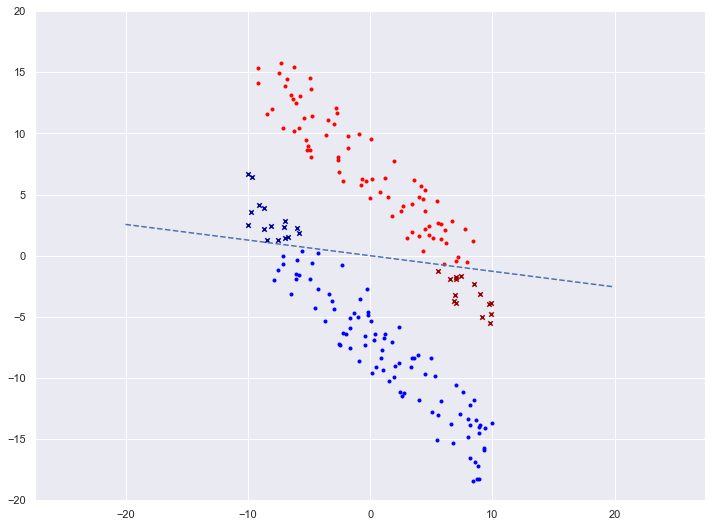

In [14]:
plot_data(lr_classifiers[0], small_data_X, small_data_Y)

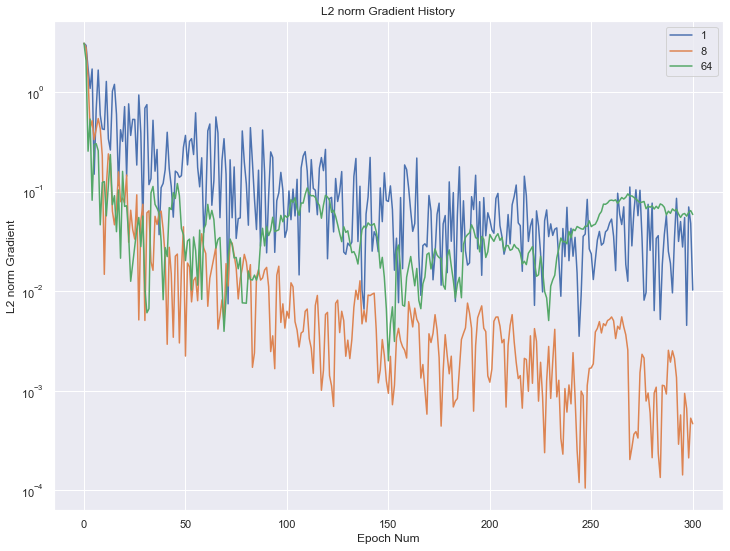

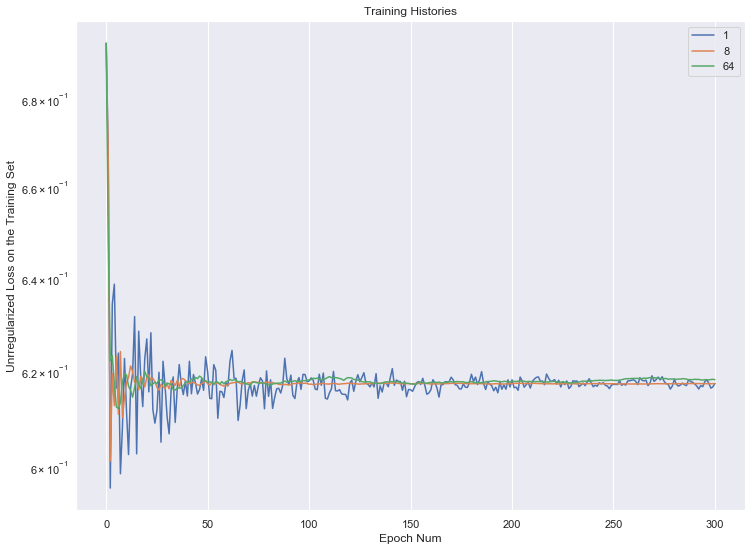

In [15]:
# Plot of L2 norm gradient history.
plt.figure(figsize=(12,9))
plt.yscale('log')

plt.ylabel('L2 norm Gradient')
plt.xlabel('Epoch Num')
plt.title('L2 norm Gradient History')
for lr_classifier in lr_classifiers:
    plt.plot([epoch for epoch in range(len(lr_classifier.l2_norm_gradient_history_))], lr_classifier.l2_norm_gradient_history_, label=lr_classifier.mini_batch_size_)
plt.legend()

# Plot of training histories
plt.figure(figsize=(12,9))
plt.title('Training Histories')
plt.xlabel('Epoch Num')
plt.yscale('log')
plt.ylabel('Unrregularized Loss on the Training Set')
for lr_classifier in lr_classifiers:
    plt.plot([epoch for epoch in range(len(lr_classifier.training_unregularized_loss_history_))], lr_classifier.training_unregularized_loss_history_, label=lr_classifier.mini_batch_size_)
plt.legend()

## Test: `pegasos` for Regularized Hinge Loss SVM ##
We can run with the initial $\eta = 0.1$ and the regularization parameter $\lambda = 100$ for $T = 300$. As $| M |$ becomes larger, the result should converge to that of the second checkpoint.

In [16]:
# Train Pegasos logistic regression classifier.
svm_classifier_obj = svm_classifier(small_data_X.shape[1])
pegasos(svm_classifier_obj, small_data_X, small_data_Y, None, None, 
        regularization=100, n_epochs=300, mini_batch_size=20)
print(svm_classifier_obj.weight_)

Epoch  50  is complete...
Epoch  100  is complete...
Epoch  150  is complete...
Epoch  200  is complete...
Epoch  250  is complete...
Epoch  300  is complete...
[-0.00437089 -0.05891949]


<a id='s8'></a>
# 8. Pegasos on Criteo CTR Prediction Data
Each function and class has been tested on a smaller dataset and passed. We can now run our classifiers on the real data. First, let's try the regularized logistic regression classifier, using `lr_classifier`. Here, $\lambda = 0.1$, and $T = 100$.

In [17]:
# Train Pegasos logistic regression classifier.
lr_classifier = logistic_regression_classifier(training_data_X.shape[1])
pegasos(lr_classifier, training_data_X, training_data_Y, validation_data_X, 
        validation_data_Y, regularization=0.1, n_epochs=100, mini_batch_size=64)
print(lr_classifier.weight_)

Epoch  50  is complete...
Epoch  100  is complete...
[-9.97062844e-04 -3.24554886e-02 -3.17024868e-01 -1.70379575e-03
 -5.19734929e-05 -4.42097298e-02 -2.56996666e-03 -3.24554886e-02
 -3.22347667e-01 -3.65527547e-02 -7.65697511e-03 -1.49690758e-02
  1.59707199e-02 -3.95476687e-01 -4.58343876e-04 -4.22801379e-03
  1.48515212e-04 -1.49690758e-02 -4.08641179e-01 -4.22801379e-03
  3.37102737e-02 -4.58343876e-04 -4.57506223e-03  1.48515212e-04]


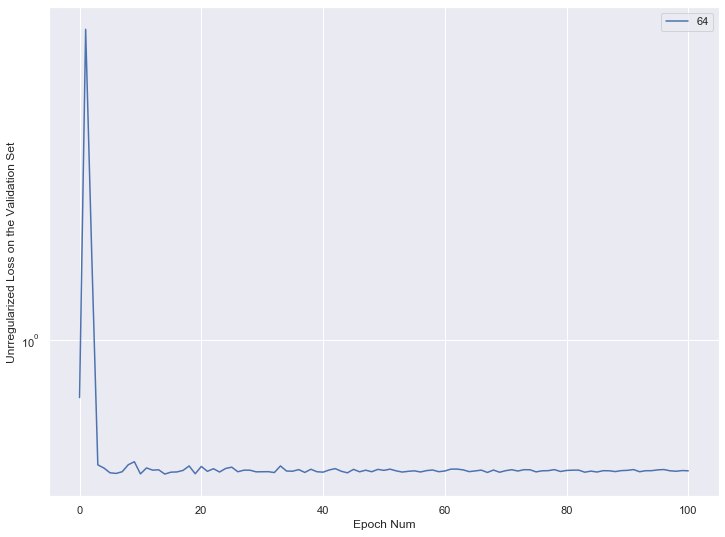

In [18]:
# Plot validation histories.
plt.figure(figsize=(12,9))
plt.yscale('log')
plt.xlabel('Epoch Num')
plt.ylabel('Unrregularized Loss on the Validation Set')
plt.plot(
    [epoch for epoch in range(len(lr_classifier.validation_unregularized_loss_history_))], 
    lr_classifier.validation_unregularized_loss_history_, 
    label=lr_classifier.mini_batch_size_)
plt.legend()

Again using $\lambda = 0.1$ and $T = 100$, we'll run on the regularized hinge loss SVM.

In [19]:
# Train Pegasos logistic regression classifier.
svm_classifier_obj = svm_classifier(training_data_X.shape[1])
pegasos(svm_classifier_obj, training_data_X, training_data_Y, validation_data_X, 
        validation_data_Y, regularization=0.1, n_epochs=100, mini_batch_size=64)
print(svm_classifier_obj.weight_)

Epoch  50  is complete...
Epoch  100  is complete...
[-4.71811214e-03 -1.47267590e-01 -2.14781601e-01 -6.76857556e-03
 -1.52330602e-03 -1.27757946e-01 -1.32660901e-02 -1.47267590e-01
 -2.41057684e-01 -1.09437827e-01 -1.83201181e-02 -5.76917017e-02
 -9.97815017e-02 -3.45872901e-01 -4.31177970e-04 -1.25183056e-02
  2.12368337e-04 -5.76917017e-02 -3.90934036e-01 -1.25183056e-02
 -4.05310793e-02 -4.31177970e-04 -1.41892877e-02  2.12368337e-04]


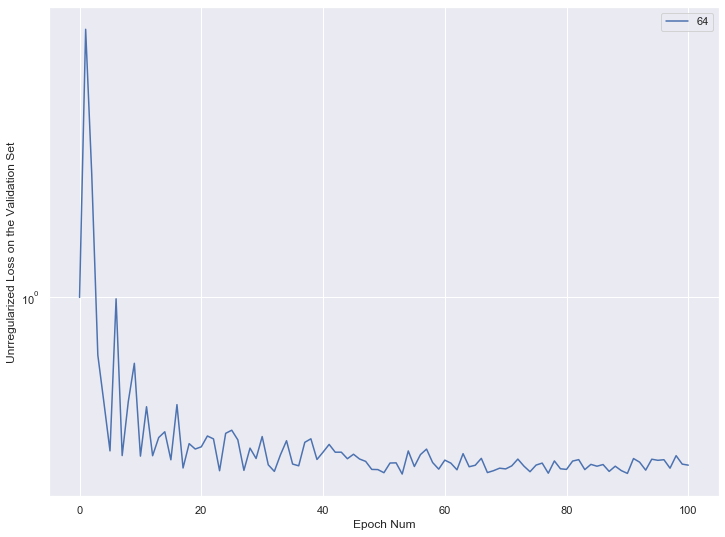

In [20]:
# Plot validation histories.
plt.figure(figsize=(12,9))
plt.yscale('log')
plt.xlabel('Epoch Num')
plt.ylabel('Unrregularized Loss on the Validation Set')
plt.plot(
    [epoch for epoch in range(len(svm_classifier_obj.validation_unregularized_loss_history_))], 
    svm_classifier_obj.validation_unregularized_loss_history_, 
    label=lr_classifier.mini_batch_size_)
plt.legend()

<a id='s9'></a>
# 9. TODO: #
- Find a setting of parameters $\lambda$ and $| M |$ that gives the best accuracy on the validation set.
  - What do you even mean by "best" here?
- Optimize the code to work on sparse data
- Improve the documentation of each class and function.
  - Consider adding docstrings and clarifying necessary comments